In [21]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import random
import math

In [22]:
data = pd.read_csv('Bcard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [23]:
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [24]:
train_data = data[data.obs_mth!='2018-11-30'].reset_index().copy()  # 利用前4个月的数据训练模型

In [25]:
val_data = data[data.obs_mth=='2018-11-30'].reset_index().copy()# 最后一个月做跨时间交叉验证

In [26]:
# 提取特征列
feat_list = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [27]:
x = train_data[feat_list]
y = train_data['bad_ind']

val_x = val_data[feat_list]
val_y = val_data['bad_ind']

In [28]:
# 创建逻辑回归对象
lr_model=LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
y_pred = lr_model.predict_proba(x)[:,1]  # 利用训练集的数据 做预测 得到坏人的概率

In [30]:
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)

In [31]:
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  # 计算训练集的KS值
train_ks

0.4467813756096739

In [32]:
y_pred = lr_model.predict_proba(val_x)[:,1]  # 利用训练集的数据 做预测 得到坏人的概率
fpr_lr_val,tpr_lr_val,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr_val - tpr_lr_val).max()  # 计算训练集的KS值
val_ks

0.40827938652621015

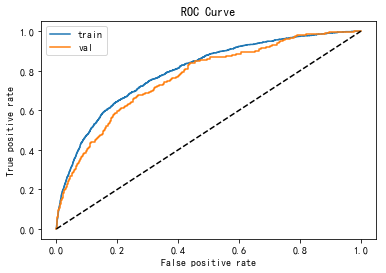

In [33]:
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label='train')
plt.plot(fpr_lr_val,tpr_lr_val,label='val')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [15]:
### 调整参数  vif <5都可以接受   共线性
from statsmodels.stats.outliers_influence import variance_inflation_factor
# statsmodels 传入numpy 的ndarray
X = np.array(x)
for i in range(X.shape[1]):
    print(variance_inflation_factor(X,i))

1.3021397545577489
1.9579535743186598
1.2899442089163669
2.9681708673324287
3.2871099722760166
3.2864932840089116
3.3175087980337827
3.2910065791107583


In [16]:
### lightgbm进行特征筛选
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=0,test_size=0.2)
def lgb_test(train_x,train_y,test_x,test_y):
    clf =lgb.LGBMClassifier(boosting_type = 'gbdt',
                           objective = 'binary',
                           metric = 'auc',
                           learning_rate = 0.1,
                           n_estimators = 24,
                           max_depth = 5,
                           num_leaves = 20,
                           max_bin = 45,
                           min_data_in_leaf = 6,
                           bagging_fraction = 0.6,
                           bagging_freq = 0,
                           feature_fraction = 0.8,
                           )
    clf.fit(train_x,train_y,eval_set = [(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return clf,clf.best_score_['valid_1']['auc'],
lgb_model , lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)
feature_importance

[1]	training's auc: 0.759467	valid_1's auc: 0.753322
[2]	training's auc: 0.809023	valid_1's auc: 0.805658
[3]	training's auc: 0.809328	valid_1's auc: 0.803858
[4]	training's auc: 0.810298	valid_1's auc: 0.801355
[5]	training's auc: 0.814873	valid_1's auc: 0.807356
[6]	training's auc: 0.816492	valid_1's auc: 0.809279
[7]	training's auc: 0.820213	valid_1's auc: 0.809208
[8]	training's auc: 0.823931	valid_1's auc: 0.812081
[9]	training's auc: 0.82696	valid_1's auc: 0.81453
[10]	training's auc: 0.827882	valid_1's auc: 0.813428
[11]	training's auc: 0.828881	valid_1's auc: 0.814226
[12]	training's auc: 0.829577	valid_1's auc: 0.813749
[13]	training's auc: 0.830406	valid_1's auc: 0.813156
[14]	training's auc: 0.830843	valid_1's auc: 0.812973
[15]	training's auc: 0.831587	valid_1's auc: 0.813501
[16]	training's auc: 0.831898	valid_1's auc: 0.813611
[17]	training's auc: 0.833751	valid_1's auc: 0.81393
[18]	training's auc: 0.834139	valid_1's auc: 0.814532
[19]	training's auc: 0.835177	valid_1's 

,importance,name
2,98,credit_info
3,62,act_info
4,54,td_score
5,50,jxl_score
7,50,rh_score
0,49,person_info
1,47,finance_info
6,46,mj_score


train_ks :  0.4482453222991063
val_ks :  0.4198642457760936


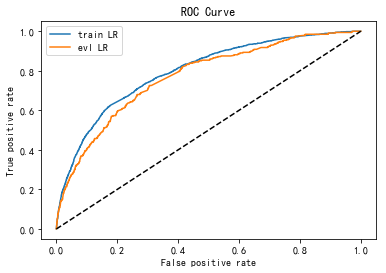

In [17]:
feature_lst = ['person_info','finance_info','credit_info','act_info']
x = train_data[feature_lst]
y = train_data['bad_ind']

val_x =  val_data[feature_lst]
val_y = val_data['bad_ind']

lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [18]:
model = lr_model
row_num, col_num = 0, 0
bins = 20 #分20箱
Y_predict = [s[1] for s in model.predict_proba(val_x)]
Y = val_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)

In [42]:
ks_lis

[(0.9998810420781638, 0.0),
 (0.9997557352213052, 1.0),
 (0.9997142467654432, 0.0),
 (0.9995800601292381, 0.0),
 (0.9995441261151846, 1.0),
 (0.9992667949429288, 0.0),
 (0.9992422500834002, 0.0),
 (0.9991624848431582, 0.0),
 (0.9989768269964682, 0.0),
 (0.9987501407960664, 1.0),
 (0.9985508303760025, 0.0),
 (0.9983528775882653, 0.0),
 (0.9983247017642491, 0.0),
 (0.9980729563774176, 0.0),
 (0.9980504228240851, 0.0),
 (0.9979132554311255, 1.0),
 (0.9978547876185625, 0.0),
 (0.9977443592066718, 0.0),
 (0.9977137330728414, 1.0),
 (0.99760644118801, 0.0),
 (0.997351442188116, 1.0),
 (0.9973446480732304, 0.0),
 (0.9970818689296547, 0.0),
 (0.9965475993114369, 0.0),
 (0.9964547693794975, 1.0),
 (0.9964384577633592, 0.0),
 (0.9963713898739128, 0.0),
 (0.9961831086180791, 1.0),
 (0.9959719234226618, 0.0),
 (0.9958253160311451, 1.0),
 (0.995691959159134, 1.0),
 (0.9956309182215204, 0.0),
 (0.9955223181836217, 0.0),
 (0.9955209054521454, 0.0),
 (0.9951877696192433, 0.0),
 (0.9950855317974946, 0.

In [19]:
#生成报告
model = lr_model
row_num, col_num = 0, 0
bins = 20 #分20箱
Y_predict = [s[1] for s in model.predict_proba(val_x)]
Y = val_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows/bins+1)# 计算每组有多少条数据
bad = sum([1 for (p, y) in ks_lis if y > 0.5]) # 计算逾期人数
good = sum([1 for (p, y) in ks_lis if y <= 0.5])   # 计算好人的人数
bad_cnt, good_cnt = 0, 0     # 累计坏人人数 ，累计好人的人数
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0.5])
    good1 = sum([1 for (p, y) in ds if y <= 0.5])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(val_y),3)  # 一箱一箱累加 到这一箱一共有多少逾期 占所有逾期的比例
    badrate = round(bad1/(bad1+good1),3)  # 一箱一箱累加 到这一箱一共有多少逾期占所有人的比例
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3) # 计算KS值
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot

,BAD,BADRATE,BAD_CNT,BAD_PCTG,GOOD,GOOD_CNT,KS
0,86,0.108,86,0.262,713,713,0.217
1,43,0.054,129,0.393,756,1469,0.299
2,29,0.036,158,0.482,770,2239,0.339
3,30,0.038,188,0.573,769,3008,0.381
4,22,0.028,210,0.640,777,3785,0.398
5,18,0.023,228,0.695,781,4566,0.403
6,18,0.023,246,0.750,781,5347,0.408
7,13,0.016,259,0.790,786,6133,0.398
8,16,0.020,275,0.838,783,6916,0.396
9,5,0.006,280,0.854,794,7710,0.361


In [40]:
list(val_repot.index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [42]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()

In [43]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [44]:
data = pd.read_csv('pima-indians-diabetes.csv')
train,test = train_test_split(data)

In [45]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [46]:
# 使用Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values,train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values,test[target_column].values)


In [47]:
#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }
watchlist = [(xgtest,'eval'),(xgtrain,'train')]
num_round = 10
bst = xgb.train(param,xgtrain,num_round,watchlist)

[0]	eval-error:0.3125	train-error:0.25
[1]	eval-error:0.244792	train-error:0.180556
[2]	eval-error:0.265625	train-error:0.180556
[3]	eval-error:0.229167	train-error:0.149306
[4]	eval-error:0.208333	train-error:0.151042
[5]	eval-error:0.229167	train-error:0.157986
[6]	eval-error:0.1875	train-error:0.15625
[7]	eval-error:0.1875	train-error:0.151042
[8]	eval-error:0.203125	train-error:0.161458
[9]	eval-error:0.203125	train-error:0.154514


In [52]:
labels = xgtest.get_label()
preds = bst.predict(xgtest)

In [53]:
sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i])/float(len(preds))

0.203125

In [55]:
bst.save_model('1.model')

In [56]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# 用pandas读入数据
data = pd.read_csv('Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 取出特征X和目标y的部分
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
train_X = train[feature_columns].values
train_y = train[target_column].values
test_X = test[feature_columns].values
test_y = test[target_column].values

# 初始化模型
xgb_classifier = xgb.XGBClassifier(n_estimators=20,\
                                   max_depth=4, \
                                   learning_rate=0.1, \
                                   subsample=0.7, \
                                   colsample_bytree=0.7)

# 拟合模型
xgb_classifier.fit(train_X, train_y)
# 使用模型预测
preds = xgb_classifier.predict(test_X)
# 判断准确率
print ('错误类为%f' %((preds!=test_y).sum()/float(test_y.shape[0])))
# 模型存储
joblib.dump(xgb_classifier, '2.model')

错误类为0.250000


['2.model']

In [57]:
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

#二分类：混淆矩阵
print("数字0和1的二分类问题")
digits = load_digits(2)
y = digits['target']
X = digits['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#多分类：混淆矩阵
print("\nIris: 多分类")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#回归问题：MSE
print("\n波士顿房价回归预测问题")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("MSE:",mean_squared_error(actuals, predictions))  # 均方误差  误差平方 再求平均

MSE: 15.989962572880902

数字0和1的二分类问题
在2折数据上的交叉验证
混淆矩阵:
[[87  0]
 [ 1 92]]
混淆矩阵:
[[91  0]
 [ 3 86]]

Iris: 多分类
在2折数据上的交叉验证
混淆矩阵:
[[19  0  0]
 [ 0 31  3]
 [ 0  1 21]]
混淆矩阵:
[[31  0  0]
 [ 0 16  0]
 [ 0  3 25]]

波士顿房价回归预测问题
在2折数据上的交叉验证
[12:12:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 9.862814929045339
[12:12:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 15.989962572880902


In [58]:
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
param_dict = {'max_depth': [2,4,6],
              'n_estimators': [50,100,200]}

clf = GridSearchCV(xgb_model, param_dict, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is n

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.8s finished


In [60]:
## 早停 避免过拟合
X = digits['data']
y = digits['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)

In [62]:
#创建xgb分类器
clf = xgb.XGBClassifier()
clf.fit(X_train,y_train,early_stopping_rounds = 10,eval_metric = 'auc',eval_set = [(X_test,y_test)])

[0]	validation_0-auc:0.999497
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999497
[2]	validation_0-auc:0.999497
[3]	validation_0-auc:0.999749
[4]	validation_0-auc:0.999749
[5]	validation_0-auc:0.999749
[6]	validation_0-auc:0.999749
[7]	validation_0-auc:0.999749
[8]	validation_0-auc:0.999749
[9]	validation_0-auc:0.999749
[10]	validation_0-auc:1
[11]	validation_0-auc:1
[12]	validation_0-auc:1
[13]	validation_0-auc:1
[14]	validation_0-auc:1
[15]	validation_0-auc:1
[16]	validation_0-auc:1
[17]	validation_0-auc:1
[18]	validation_0-auc:1
[19]	validation_0-auc:1
[20]	validation_0-auc:1
Stopping. Best iteration:
[10]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [63]:
iris = load_iris()
y = iris['target']
X = iris['data']

In [64]:
xgb_model = xgb.XGBClassifier().fit(X,y)

In [68]:
feature_importances = xgb_model.feature_importances_

In [70]:
indices = np.argsort(feature_importances)[::-1]
feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

for index in indices:
    print("特征 %s 重要度为 %f" %(feature_names[index], feature_importances[index]))

特征 petal_length 重要度为 0.599222
特征 petal_width 重要度为 0.354334
特征 sepal_width 重要度为 0.034046
特征 sepal_length 重要度为 0.012397


In [72]:
data = pd.read_csv('Bcard.txt')
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

### lightGBM跨时间交叉验证

In [73]:
# 根据时间对数据进行排序
df_train = df_train.sort_values(by='obs_mth',ascending = False)

In [75]:
rank_list = []
for i in range(1,len(df_train)+1):
    rank_list.append(i)

In [77]:
#把生成的序号 合并到数据中
df_train['rank'] = rank_list

In [79]:
df_train['rank'] = df_train['rank']/len(df_train) # 计算每一条数据 在时间这个维度上 在整个数据集的百分位的位置

In [81]:
# 根据时间排序的rank值把所有的数据分成5箱
pct_lst=[]
for x in df_train['rank']:
    if x <= 0.2:
        x = 1
    elif x <= 0.4:
        x = 2
    elif x <= 0.6:
        x = 3
    elif x <= 0.8:
        x = 4
    else:
        x = 5
    pct_lst.append(x)
df_train['rank'] = pct_lst

In [82]:
df_train

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info,rank
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949,1
33407,33407,2018-10-31,0.0,A2810176,0.146055,0.079922,0.250568,0.045240,0.766906,0.413713,0.013863,0.023810,0.00,0.269231,1
33383,33383,2018-10-31,0.0,A2807687,0.551366,0.300781,0.225007,0.045447,0.735733,0.684182,-0.261014,0.071429,0.03,0.269231,1
33379,33379,2018-10-31,0.0,A2807232,0.708547,0.769513,0.928457,0.739716,0.947453,0.361551,-0.128677,0.047619,0.00,0.269231,1
33376,33376,2018-10-31,0.0,A2806932,0.482248,0.116658,0.286273,0.056618,0.047024,0.890433,0.078853,0.047619,0.00,0.269231,1
33374,33374,2018-10-31,0.0,A2806817,0.003063,0.533693,0.007876,0.547950,0.811325,0.277552,-0.128677,0.071429,0.02,0.269231,1
33373,33373,2018-10-31,0.0,A2806802,0.462954,0.420593,0.800949,0.212851,0.486658,0.138792,-0.053718,0.023810,0.20,0.269231,1
33369,33369,2018-10-31,0.0,A2806416,0.698203,0.164079,0.634027,0.013182,0.883847,0.174621,-0.322581,0.071429,0.06,0.269231,1
33353,33353,2018-10-31,0.0,A2804716,0.070496,0.822415,0.830328,0.520334,0.478299,0.835485,0.078853,0.047619,0.00,0.269231,1
33351,33351,2018-10-31,0.0,A2804589,0.583609,0.233510,0.088810,0.698651,0.197491,0.411140,-0.053718,0.023810,0.02,0.269231,1


In [89]:
# 使用lgbm 进行跨时间的交叉验证
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=800,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
        num_iterations = 800 #迭代次数
    )
    clf.fit(train_x,train_y,  #训练集的特征和目标 
            eval_set=[(train_x,train_y),(test_x,test_y)],  #验证数据
            eval_metric='auc',                             # 评估损失的指标 这里传入的是auc
            early_stopping_rounds=100)                     # early_stopping 迭代次数 
    print(clf.n_features_)
    return clf,clf.best_score_['valid_1']['auc']

In [87]:
lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [132]:
# 准备用来保存 特征结果   训练集ks值 测试集ks值的list
feature_lst ={}
ks_train_lst=[]
ks_test_lst = []
for rk in set(df_train['rank']):
    #遍历rank 中的每一箱 一共是5箱
    # 遍历到当前的箱 作为交叉验证的测试数据
    ttest = df_train[df_train['rank']==rk]
    # 剩下的4箱作为训练数据
    ttrain = df_train[df_train['rank']!=rk]
    
    train = ttrain[lst]  # 从交叉验证的训练集中取出特征
    train_y = ttrain.bad_ind   #从交叉验证的训练集中取出目标
    
    test = ttest[lst]
    test_y = ttest.bad_ind
    
    # 调用封装好的LGB_test函数，传入训练集和测试集数据 
    # 返回一个lgbm模型 和auc的值
    model,auc = LGB_test(train,train_y,test,test_y)
    # 从model 中获取传入特征的重要程度
    feature = pd.DataFrame({'name':model.booster_.feature_name(),'importance':model.feature_importances_}).sort_values(by=['importance'],ascending = False)
    
    #计算训练集 测试集 验证集上的ks和auc
    y_pred_train_lgb = model.predict_proba(train)[:,1]   #取出训练集 测试集 预测结果 是坏人的概率
    y_pred_test_lgb = model.predict_proba(test)[:,1]
    train_fpr_lgb,train_tpr_lgb,_ = roc_curve(train_y,y_pred_train_lgb) # 计算训练集和测试集的 tpr和fpr
    test_fpr_lgb,test_tpr_lgb,_ = roc_curve(test_y,y_pred_test_lgb)
    train_ks = abs(train_fpr_lgb-train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb-test_tpr_lgb).max()
    
    train_auc = metrics.auc(train_fpr_lgb,train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb,test_tpr_lgb)
    
    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)
    
    feature_lst[str(rk)] = feature[feature.importance>=20].name

[1]	training's auc: 0.737137	training's binary_logloss: 0.0832707	valid_1's auc: 0.712178	valid_1's binary_logloss: 0.12168
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.779956	training's binary_logloss: 0.0821329	valid_1's auc: 0.773038	valid_1's binary_logloss: 0.119538
[3]	training's auc: 0.787657	training's binary_logloss: 0.0816239	valid_1's auc: 0.759829	valid_1's binary_logloss: 0.118773
[4]	training's auc: 0.787083	training's binary_logloss: 0.0811169	valid_1's auc: 0.758327	valid_1's binary_logloss: 0.117919
[5]	training's auc: 0.791363	training's binary_logloss: 0.0803378	valid_1's auc: 0.768679	valid_1's binary_logloss: 0.116488
[6]	training's auc: 0.797614	training's binary_logloss: 0.0796057	valid_1's auc: 0.779753	valid_1's binary_logloss: 0.11516
[7]	training's auc: 0.796785	training's binary_logloss: 0.0792409	valid_1's auc: 0.779428	valid_1's binary_logloss: 0.114638
[8]	training's auc: 0.799178	training's binary_logloss: 0.0786552

[74]	training's auc: 0.8177	training's binary_logloss: 0.0718338	valid_1's auc: 0.786248	valid_1's binary_logloss: 0.106055
[75]	training's auc: 0.817776	training's binary_logloss: 0.0718139	valid_1's auc: 0.786254	valid_1's binary_logloss: 0.10606
[76]	training's auc: 0.817746	training's binary_logloss: 0.0717932	valid_1's auc: 0.786234	valid_1's binary_logloss: 0.106069
[77]	training's auc: 0.817805	training's binary_logloss: 0.0717813	valid_1's auc: 0.786385	valid_1's binary_logloss: 0.106051
[78]	training's auc: 0.81785	training's binary_logloss: 0.0717608	valid_1's auc: 0.786448	valid_1's binary_logloss: 0.106048
[79]	training's auc: 0.817856	training's binary_logloss: 0.0717497	valid_1's auc: 0.786389	valid_1's binary_logloss: 0.106043
[80]	training's auc: 0.817805	training's binary_logloss: 0.0717335	valid_1's auc: 0.78636	valid_1's binary_logloss: 0.106046
[81]	training's auc: 0.817929	training's binary_logloss: 0.0717176	valid_1's auc: 0.786105	valid_1's binary_logloss: 0.1060

[36]	training's auc: 0.808827	training's binary_logloss: 0.0757494	valid_1's auc: 0.79308	valid_1's binary_logloss: 0.096316
[37]	training's auc: 0.809183	training's binary_logloss: 0.0756719	valid_1's auc: 0.793709	valid_1's binary_logloss: 0.0962386
[38]	training's auc: 0.809257	training's binary_logloss: 0.0756061	valid_1's auc: 0.794152	valid_1's binary_logloss: 0.0961597
[39]	training's auc: 0.809687	training's binary_logloss: 0.0755395	valid_1's auc: 0.795144	valid_1's binary_logloss: 0.0960838
[40]	training's auc: 0.810185	training's binary_logloss: 0.0754849	valid_1's auc: 0.795615	valid_1's binary_logloss: 0.0960232
[41]	training's auc: 0.810688	training's binary_logloss: 0.0754276	valid_1's auc: 0.795945	valid_1's binary_logloss: 0.0959741
[42]	training's auc: 0.810748	training's binary_logloss: 0.0753825	valid_1's auc: 0.795922	valid_1's binary_logloss: 0.0959403
[43]	training's auc: 0.811063	training's binary_logloss: 0.0753409	valid_1's auc: 0.796153	valid_1's binary_loglo

[121]	training's auc: 0.818331	training's binary_logloss: 0.0740275	valid_1's auc: 0.801952	valid_1's binary_logloss: 0.0950769
[122]	training's auc: 0.818439	training's binary_logloss: 0.0740214	valid_1's auc: 0.801875	valid_1's binary_logloss: 0.0950907
[123]	training's auc: 0.818463	training's binary_logloss: 0.0740155	valid_1's auc: 0.80186	valid_1's binary_logloss: 0.0950991
[124]	training's auc: 0.818456	training's binary_logloss: 0.0739921	valid_1's auc: 0.801753	valid_1's binary_logloss: 0.095094
[125]	training's auc: 0.818562	training's binary_logloss: 0.0739821	valid_1's auc: 0.801819	valid_1's binary_logloss: 0.0950942
[126]	training's auc: 0.818554	training's binary_logloss: 0.0739783	valid_1's auc: 0.801738	valid_1's binary_logloss: 0.0951069
[127]	training's auc: 0.81862	training's binary_logloss: 0.0739709	valid_1's auc: 0.801746	valid_1's binary_logloss: 0.0951167
[128]	training's auc: 0.818659	training's binary_logloss: 0.0739662	valid_1's auc: 0.801785	valid_1's binar

[186]	training's auc: 0.82134	training's binary_logloss: 0.0736078	valid_1's auc: 0.802099	valid_1's binary_logloss: 0.0950544
[187]	training's auc: 0.821335	training's binary_logloss: 0.0736012	valid_1's auc: 0.802016	valid_1's binary_logloss: 0.0950511
[188]	training's auc: 0.821401	training's binary_logloss: 0.0735963	valid_1's auc: 0.801984	valid_1's binary_logloss: 0.0950564
[189]	training's auc: 0.821433	training's binary_logloss: 0.073592	valid_1's auc: 0.801796	valid_1's binary_logloss: 0.0950681
[190]	training's auc: 0.821438	training's binary_logloss: 0.0735892	valid_1's auc: 0.801722	valid_1's binary_logloss: 0.0950749
[191]	training's auc: 0.821501	training's binary_logloss: 0.0735838	valid_1's auc: 0.801653	valid_1's binary_logloss: 0.0950755
[192]	training's auc: 0.821515	training's binary_logloss: 0.0735815	valid_1's auc: 0.80165	valid_1's binary_logloss: 0.0950761
[193]	training's auc: 0.82166	training's binary_logloss: 0.0735721	valid_1's auc: 0.801594	valid_1's binary

[55]	training's auc: 0.807071	training's binary_logloss: 0.0848348	valid_1's auc: 0.815044	valid_1's binary_logloss: 0.0562107
[56]	training's auc: 0.807192	training's binary_logloss: 0.0848079	valid_1's auc: 0.815161	valid_1's binary_logloss: 0.0561835
[57]	training's auc: 0.807266	training's binary_logloss: 0.0847812	valid_1's auc: 0.815412	valid_1's binary_logloss: 0.0561607
[58]	training's auc: 0.807522	training's binary_logloss: 0.0847539	valid_1's auc: 0.815017	valid_1's binary_logloss: 0.0561352
[59]	training's auc: 0.807756	training's binary_logloss: 0.0847271	valid_1's auc: 0.815526	valid_1's binary_logloss: 0.0561127
[60]	training's auc: 0.807906	training's binary_logloss: 0.0847052	valid_1's auc: 0.815651	valid_1's binary_logloss: 0.0560871
[61]	training's auc: 0.807908	training's binary_logloss: 0.0846771	valid_1's auc: 0.81586	valid_1's binary_logloss: 0.0560598
[62]	training's auc: 0.807825	training's binary_logloss: 0.0846535	valid_1's auc: 0.815716	valid_1's binary_logl

[136]	training's auc: 0.812889	training's binary_logloss: 0.0838366	valid_1's auc: 0.816153	valid_1's binary_logloss: 0.0554912
[137]	training's auc: 0.812918	training's binary_logloss: 0.0838319	valid_1's auc: 0.816121	valid_1's binary_logloss: 0.0554858
[138]	training's auc: 0.813006	training's binary_logloss: 0.0838246	valid_1's auc: 0.815959	valid_1's binary_logloss: 0.0554931
[139]	training's auc: 0.813071	training's binary_logloss: 0.0838158	valid_1's auc: 0.815998	valid_1's binary_logloss: 0.0554945
[140]	training's auc: 0.813133	training's binary_logloss: 0.0838078	valid_1's auc: 0.815881	valid_1's binary_logloss: 0.0554977
[141]	training's auc: 0.813199	training's binary_logloss: 0.083801	valid_1's auc: 0.815823	valid_1's binary_logloss: 0.0555011
[142]	training's auc: 0.813305	training's binary_logloss: 0.0837922	valid_1's auc: 0.815685	valid_1's binary_logloss: 0.055499
[143]	training's auc: 0.813375	training's binary_logloss: 0.0837872	valid_1's auc: 0.815654	valid_1's bina

[36]	training's auc: 0.80415	training's binary_logloss: 0.084594	valid_1's auc: 0.819485	valid_1's binary_logloss: 0.0617198
[37]	training's auc: 0.804479	training's binary_logloss: 0.0845205	valid_1's auc: 0.819578	valid_1's binary_logloss: 0.0616303
[38]	training's auc: 0.804591	training's binary_logloss: 0.0844439	valid_1's auc: 0.819611	valid_1's binary_logloss: 0.061551
[39]	training's auc: 0.804917	training's binary_logloss: 0.0843732	valid_1's auc: 0.81937	valid_1's binary_logloss: 0.0614767
[40]	training's auc: 0.805168	training's binary_logloss: 0.084307	valid_1's auc: 0.81904	valid_1's binary_logloss: 0.0614045
[41]	training's auc: 0.805101	training's binary_logloss: 0.0842394	valid_1's auc: 0.819597	valid_1's binary_logloss: 0.0613289
[42]	training's auc: 0.805366	training's binary_logloss: 0.0841893	valid_1's auc: 0.819161	valid_1's binary_logloss: 0.0612731
[43]	training's auc: 0.805585	training's binary_logloss: 0.0841439	valid_1's auc: 0.819247	valid_1's binary_logloss: 

[111]	training's auc: 0.812325	training's binary_logloss: 0.0828061	valid_1's auc: 0.821159	valid_1's binary_logloss: 0.0600955
[112]	training's auc: 0.812362	training's binary_logloss: 0.082795	valid_1's auc: 0.821345	valid_1's binary_logloss: 0.0600771
[113]	training's auc: 0.812404	training's binary_logloss: 0.0827782	valid_1's auc: 0.821364	valid_1's binary_logloss: 0.0600613
[114]	training's auc: 0.812475	training's binary_logloss: 0.0827683	valid_1's auc: 0.82134	valid_1's binary_logloss: 0.0600647
[115]	training's auc: 0.812525	training's binary_logloss: 0.0827628	valid_1's auc: 0.821321	valid_1's binary_logloss: 0.060064
[116]	training's auc: 0.812595	training's binary_logloss: 0.0827561	valid_1's auc: 0.821365	valid_1's binary_logloss: 0.0600534
[117]	training's auc: 0.812622	training's binary_logloss: 0.0827515	valid_1's auc: 0.821384	valid_1's binary_logloss: 0.0600524
[118]	training's auc: 0.812656	training's binary_logloss: 0.0827469	valid_1's auc: 0.821383	valid_1's binar

[191]	training's auc: 0.816213	training's binary_logloss: 0.0822793	valid_1's auc: 0.820821	valid_1's binary_logloss: 0.0600409
[192]	training's auc: 0.816249	training's binary_logloss: 0.0822733	valid_1's auc: 0.820999	valid_1's binary_logloss: 0.0600369
[193]	training's auc: 0.816205	training's binary_logloss: 0.0822664	valid_1's auc: 0.821091	valid_1's binary_logloss: 0.0600323
[194]	training's auc: 0.816235	training's binary_logloss: 0.0822621	valid_1's auc: 0.820952	valid_1's binary_logloss: 0.0600387
[195]	training's auc: 0.816252	training's binary_logloss: 0.0822505	valid_1's auc: 0.820979	valid_1's binary_logloss: 0.0600292
[196]	training's auc: 0.816315	training's binary_logloss: 0.0822465	valid_1's auc: 0.821024	valid_1's binary_logloss: 0.0600296
[197]	training's auc: 0.816356	training's binary_logloss: 0.0822341	valid_1's auc: 0.821042	valid_1's binary_logloss: 0.0600237
[198]	training's auc: 0.816366	training's binary_logloss: 0.0822317	valid_1's auc: 0.820935	valid_1's bi

[33]	training's auc: 0.814973	training's binary_logloss: 0.0800265	valid_1's auc: 0.785014	valid_1's binary_logloss: 0.0804548
[34]	training's auc: 0.814946	training's binary_logloss: 0.0799604	valid_1's auc: 0.784776	valid_1's binary_logloss: 0.0804281
[35]	training's auc: 0.815168	training's binary_logloss: 0.07987	valid_1's auc: 0.784543	valid_1's binary_logloss: 0.0803984
[36]	training's auc: 0.815285	training's binary_logloss: 0.0798056	valid_1's auc: 0.784537	valid_1's binary_logloss: 0.0803779
[37]	training's auc: 0.816009	training's binary_logloss: 0.0797318	valid_1's auc: 0.785455	valid_1's binary_logloss: 0.0803199
[38]	training's auc: 0.816104	training's binary_logloss: 0.0796535	valid_1's auc: 0.785651	valid_1's binary_logloss: 0.0802644
[39]	training's auc: 0.816478	training's binary_logloss: 0.0795767	valid_1's auc: 0.786218	valid_1's binary_logloss: 0.0801931
[40]	training's auc: 0.816644	training's binary_logloss: 0.0795068	valid_1's auc: 0.785947	valid_1's binary_loglo

[106]	training's auc: 0.823391	training's binary_logloss: 0.0780711	valid_1's auc: 0.787651	valid_1's binary_logloss: 0.079327
[107]	training's auc: 0.823408	training's binary_logloss: 0.0780652	valid_1's auc: 0.787602	valid_1's binary_logloss: 0.0793386
[108]	training's auc: 0.823459	training's binary_logloss: 0.0780561	valid_1's auc: 0.787448	valid_1's binary_logloss: 0.0793527
[109]	training's auc: 0.823511	training's binary_logloss: 0.0780513	valid_1's auc: 0.787332	valid_1's binary_logloss: 0.0793512
[110]	training's auc: 0.823507	training's binary_logloss: 0.0780462	valid_1's auc: 0.78735	valid_1's binary_logloss: 0.0793553
[111]	training's auc: 0.823527	training's binary_logloss: 0.0780347	valid_1's auc: 0.787337	valid_1's binary_logloss: 0.07935
[112]	training's auc: 0.82369	training's binary_logloss: 0.0780229	valid_1's auc: 0.787286	valid_1's binary_logloss: 0.0793605
[113]	training's auc: 0.823708	training's binary_logloss: 0.0780184	valid_1's auc: 0.787252	valid_1's binary_

[174]	training's auc: 0.826317	training's binary_logloss: 0.0776589	valid_1's auc: 0.787618	valid_1's binary_logloss: 0.0793724
[175]	training's auc: 0.826365	training's binary_logloss: 0.0776509	valid_1's auc: 0.787598	valid_1's binary_logloss: 0.0793771
[176]	training's auc: 0.826413	training's binary_logloss: 0.0776469	valid_1's auc: 0.787607	valid_1's binary_logloss: 0.0793783
[177]	training's auc: 0.826463	training's binary_logloss: 0.077643	valid_1's auc: 0.787621	valid_1's binary_logloss: 0.0793848
[178]	training's auc: 0.826527	training's binary_logloss: 0.077638	valid_1's auc: 0.787618	valid_1's binary_logloss: 0.0793778
[179]	training's auc: 0.826526	training's binary_logloss: 0.0776327	valid_1's auc: 0.787583	valid_1's binary_logloss: 0.0793926
[180]	training's auc: 0.826577	training's binary_logloss: 0.0776282	valid_1's auc: 0.787546	valid_1's binary_logloss: 0.0793975
[181]	training's auc: 0.826595	training's binary_logloss: 0.0776268	valid_1's auc: 0.787523	valid_1's bina

In [94]:
train_ks = np.mean(ks_train_lst)

In [95]:
train_ks

0.4893612378549733

In [96]:
test_ks = np.mean(ks_test_lst)

In [97]:
test_ks

0.4717273838273967

In [113]:
df_train['rank'].groupby(df_train['rank']).count()

rank
1    15966
2    15966
3    15966
4    15966
5    15967
Name: rank, dtype: int64

In [109]:
feature_lst

{'1': 1    finance_info
 Name: name, dtype: object, '2': 1    finance_info
 0     person_info
 2     credit_info
 3        act_info
 6        mj_score
 Name: name, dtype: object, '3': 1    finance_info
 0     person_info
 2     credit_info
 3        act_info
 Name: name, dtype: object, '4': 1    finance_info
 0     person_info
 2     credit_info
 3        act_info
 6        mj_score
 4        td_score
 Name: name, dtype: object, '5': 1    finance_info
 2     credit_info
 0     person_info
 3        act_info
 6        mj_score
 4        td_score
 Name: name, dtype: object}

In [98]:
ft_lst={}
for i in range(1,6):
    ft_lst[str(i)] = feature_lst[str(i)]

In [105]:
fn_lst=list(set(ft_lst['1']) & set(ft_lst['2']) 
    & set(ft_lst['3']) & set(ft_lst['4']) &set(ft_lst['5']))

In [123]:
feature_names=[]

In [134]:
#定义lgb函数
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=800,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
        num_iterations = 800 #迭代次数
    )
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)
    print(clf.n_features_)

    return clf,clf.best_score_[ 'valid_1']['auc']
feature_lst = {}
ks_train_lst = []
ks_test_lst = []
features = []
for rk in set(df_train['rank']):   
    # 1，2，3，4，5
    # 测试集8.18以后作为跨时间验证集
    
    #定义模型训练集与测试集
    ttest = df_train[df_train['rank'] ==  rk]
    ttrain = df_train[df_train['rank'] !=  rk]
    
    train = ttrain[lst]
    train_y = ttrain.bad_ind
    
    test = ttest[lst]
    test_y = ttest.bad_ind    
    
#     start = time.time()
    model,auc = LGB_test(train,train_y,test,test_y)                    
#     end = time.time()
    
    #模型贡献度放在feture中
    feature = pd.DataFrame(
                {'name' : model.booster_.feature_name(),
                'importance' : model.feature_importances_
              }).sort_values(by =  ['importance'],ascending = False)
    features.append(feature)
       
    #计算训练集、测试集、验证集上的KS和AUC

    y_pred_train_lgb = model.predict_proba(train)[:, 1]
    y_pred_test_lgb = model.predict_proba(test)[:, 1]


    train_fpr_lgb, train_tpr_lgb, _ = roc_curve(train_y, y_pred_train_lgb)
    test_fpr_lgb, test_tpr_lgb, _ = roc_curve(test_y, y_pred_test_lgb)


    train_ks = abs(train_fpr_lgb - train_tpr_lgb).max()
    test_ks = abs(test_fpr_lgb - test_tpr_lgb).max()


    train_auc = metrics.auc(train_fpr_lgb, train_tpr_lgb)
    test_auc = metrics.auc(test_fpr_lgb, test_tpr_lgb)
    
    ks_train_lst.append(train_ks)
    ks_test_lst.append(test_ks)    

    feature_lst[str(rk)] = feature[feature['importance']>=14].name
    
train_ks = np.mean(ks_train_lst)
test_ks = np.mean(ks_test_lst)

ft_lst = {}
for i in range(1,6):
    ft_lst[str(i)] = feature_lst[str(i)]

fn_lst=list(set(ft_lst['1']) & set(ft_lst['2']) 
    & set(ft_lst['3']) & set(ft_lst['4']) &set(ft_lst['5']))


[1]	training's auc: 0.737137	training's binary_logloss: 0.0832707	valid_1's auc: 0.712178	valid_1's binary_logloss: 0.12168
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.779956	training's binary_logloss: 0.0821329	valid_1's auc: 0.773038	valid_1's binary_logloss: 0.119538
[3]	training's auc: 0.787657	training's binary_logloss: 0.0816239	valid_1's auc: 0.759829	valid_1's binary_logloss: 0.118773
[4]	training's auc: 0.787083	training's binary_logloss: 0.0811169	valid_1's auc: 0.758327	valid_1's binary_logloss: 0.117919
[5]	training's auc: 0.791363	training's binary_logloss: 0.0803378	valid_1's auc: 0.768679	valid_1's binary_logloss: 0.116488
[6]	training's auc: 0.797614	training's binary_logloss: 0.0796057	valid_1's auc: 0.779753	valid_1's binary_logloss: 0.11516
[7]	training's auc: 0.796785	training's binary_logloss: 0.0792409	valid_1's auc: 0.779428	valid_1's binary_logloss: 0.114638
[8]	training's auc: 0.799178	training's binary_logloss: 0.0786552

[76]	training's auc: 0.817746	training's binary_logloss: 0.0717932	valid_1's auc: 0.786234	valid_1's binary_logloss: 0.106069
[77]	training's auc: 0.817805	training's binary_logloss: 0.0717813	valid_1's auc: 0.786385	valid_1's binary_logloss: 0.106051
[78]	training's auc: 0.81785	training's binary_logloss: 0.0717608	valid_1's auc: 0.786448	valid_1's binary_logloss: 0.106048
[79]	training's auc: 0.817856	training's binary_logloss: 0.0717497	valid_1's auc: 0.786389	valid_1's binary_logloss: 0.106043
[80]	training's auc: 0.817805	training's binary_logloss: 0.0717335	valid_1's auc: 0.78636	valid_1's binary_logloss: 0.106046
[81]	training's auc: 0.817929	training's binary_logloss: 0.0717176	valid_1's auc: 0.786105	valid_1's binary_logloss: 0.106076
[82]	training's auc: 0.817987	training's binary_logloss: 0.0717058	valid_1's auc: 0.786264	valid_1's binary_logloss: 0.106065
[83]	training's auc: 0.818062	training's binary_logloss: 0.0716967	valid_1's auc: 0.786325	valid_1's binary_logloss: 0.1

[26]	training's auc: 0.806634	training's binary_logloss: 0.0766375	valid_1's auc: 0.790566	valid_1's binary_logloss: 0.0972061
[27]	training's auc: 0.806535	training's binary_logloss: 0.0765064	valid_1's auc: 0.79047	valid_1's binary_logloss: 0.0970804
[28]	training's auc: 0.807531	training's binary_logloss: 0.0764124	valid_1's auc: 0.791324	valid_1's binary_logloss: 0.0969867
[29]	training's auc: 0.80751	training's binary_logloss: 0.0763011	valid_1's auc: 0.79131	valid_1's binary_logloss: 0.0968865
[30]	training's auc: 0.807677	training's binary_logloss: 0.0761941	valid_1's auc: 0.791657	valid_1's binary_logloss: 0.0967636
[31]	training's auc: 0.808178	training's binary_logloss: 0.0760931	valid_1's auc: 0.792211	valid_1's binary_logloss: 0.0966492
[32]	training's auc: 0.808237	training's binary_logloss: 0.0760263	valid_1's auc: 0.791882	valid_1's binary_logloss: 0.0966079
[33]	training's auc: 0.808377	training's binary_logloss: 0.0759377	valid_1's auc: 0.792189	valid_1's binary_loglos

[105]	training's auc: 0.817076	training's binary_logloss: 0.0741712	valid_1's auc: 0.802443	valid_1's binary_logloss: 0.0950379
[106]	training's auc: 0.8174	training's binary_logloss: 0.0741545	valid_1's auc: 0.802431	valid_1's binary_logloss: 0.0950465
[107]	training's auc: 0.817488	training's binary_logloss: 0.074146	valid_1's auc: 0.802481	valid_1's binary_logloss: 0.0950438
[108]	training's auc: 0.8176	training's binary_logloss: 0.0741379	valid_1's auc: 0.802441	valid_1's binary_logloss: 0.0950526
[109]	training's auc: 0.817602	training's binary_logloss: 0.0741324	valid_1's auc: 0.802397	valid_1's binary_logloss: 0.0950563
[110]	training's auc: 0.817592	training's binary_logloss: 0.0741088	valid_1's auc: 0.802309	valid_1's binary_logloss: 0.0950496
[111]	training's auc: 0.817624	training's binary_logloss: 0.0741037	valid_1's auc: 0.802315	valid_1's binary_logloss: 0.0950413
[112]	training's auc: 0.817633	training's binary_logloss: 0.0740973	valid_1's auc: 0.802264	valid_1's binary_

[176]	training's auc: 0.820943	training's binary_logloss: 0.073649	valid_1's auc: 0.8022	valid_1's binary_logloss: 0.0950437
[177]	training's auc: 0.820964	training's binary_logloss: 0.0736455	valid_1's auc: 0.802107	valid_1's binary_logloss: 0.0950517
[178]	training's auc: 0.82104	training's binary_logloss: 0.0736381	valid_1's auc: 0.802185	valid_1's binary_logloss: 0.0950498
[179]	training's auc: 0.821046	training's binary_logloss: 0.0736369	valid_1's auc: 0.802196	valid_1's binary_logloss: 0.095051
[180]	training's auc: 0.821092	training's binary_logloss: 0.0736316	valid_1's auc: 0.802213	valid_1's binary_logloss: 0.0950498
[181]	training's auc: 0.821091	training's binary_logloss: 0.0736285	valid_1's auc: 0.802195	valid_1's binary_logloss: 0.0950463
[182]	training's auc: 0.821173	training's binary_logloss: 0.073623	valid_1's auc: 0.802054	valid_1's binary_logloss: 0.0950586
[183]	training's auc: 0.821276	training's binary_logloss: 0.0736181	valid_1's auc: 0.802058	valid_1's binary_l

[61]	training's auc: 0.807908	training's binary_logloss: 0.0846771	valid_1's auc: 0.81586	valid_1's binary_logloss: 0.0560598
[62]	training's auc: 0.807825	training's binary_logloss: 0.0846535	valid_1's auc: 0.815716	valid_1's binary_logloss: 0.0560395
[63]	training's auc: 0.807979	training's binary_logloss: 0.0846277	valid_1's auc: 0.815459	valid_1's binary_logloss: 0.0560157
[64]	training's auc: 0.808122	training's binary_logloss: 0.084603	valid_1's auc: 0.815693	valid_1's binary_logloss: 0.0559968
[65]	training's auc: 0.808225	training's binary_logloss: 0.084582	valid_1's auc: 0.815806	valid_1's binary_logloss: 0.0559781
[66]	training's auc: 0.80833	training's binary_logloss: 0.0845667	valid_1's auc: 0.815883	valid_1's binary_logloss: 0.0559607
[67]	training's auc: 0.808585	training's binary_logloss: 0.0845463	valid_1's auc: 0.815894	valid_1's binary_logloss: 0.0559384
[68]	training's auc: 0.808854	training's binary_logloss: 0.0845274	valid_1's auc: 0.815614	valid_1's binary_logloss

[134]	training's auc: 0.812865	training's binary_logloss: 0.0838465	valid_1's auc: 0.816282	valid_1's binary_logloss: 0.0554834
[135]	training's auc: 0.812863	training's binary_logloss: 0.0838421	valid_1's auc: 0.816134	valid_1's binary_logloss: 0.0554914
[136]	training's auc: 0.812889	training's binary_logloss: 0.0838366	valid_1's auc: 0.816153	valid_1's binary_logloss: 0.0554912
[137]	training's auc: 0.812918	training's binary_logloss: 0.0838319	valid_1's auc: 0.816121	valid_1's binary_logloss: 0.0554858
[138]	training's auc: 0.813006	training's binary_logloss: 0.0838246	valid_1's auc: 0.815959	valid_1's binary_logloss: 0.0554931
[139]	training's auc: 0.813071	training's binary_logloss: 0.0838158	valid_1's auc: 0.815998	valid_1's binary_logloss: 0.0554945
[140]	training's auc: 0.813133	training's binary_logloss: 0.0838078	valid_1's auc: 0.815881	valid_1's binary_logloss: 0.0554977
[141]	training's auc: 0.813199	training's binary_logloss: 0.083801	valid_1's auc: 0.815823	valid_1's bin

[32]	training's auc: 0.8032	training's binary_logloss: 0.0848904	valid_1's auc: 0.818715	valid_1's binary_logloss: 0.062045
[33]	training's auc: 0.803554	training's binary_logloss: 0.084791	valid_1's auc: 0.818353	valid_1's binary_logloss: 0.0619613
[34]	training's auc: 0.803704	training's binary_logloss: 0.0847369	valid_1's auc: 0.818047	valid_1's binary_logloss: 0.06189
[35]	training's auc: 0.804011	training's binary_logloss: 0.0846602	valid_1's auc: 0.81893	valid_1's binary_logloss: 0.061801
[36]	training's auc: 0.80415	training's binary_logloss: 0.084594	valid_1's auc: 0.819485	valid_1's binary_logloss: 0.0617198
[37]	training's auc: 0.804479	training's binary_logloss: 0.0845205	valid_1's auc: 0.819578	valid_1's binary_logloss: 0.0616303
[38]	training's auc: 0.804591	training's binary_logloss: 0.0844439	valid_1's auc: 0.819611	valid_1's binary_logloss: 0.061551
[39]	training's auc: 0.804917	training's binary_logloss: 0.0843732	valid_1's auc: 0.81937	valid_1's binary_logloss: 0.0614

[100]	training's auc: 0.811672	training's binary_logloss: 0.0828978	valid_1's auc: 0.821349	valid_1's binary_logloss: 0.0601376
[101]	training's auc: 0.811739	training's binary_logloss: 0.0828873	valid_1's auc: 0.821272	valid_1's binary_logloss: 0.0601442
[102]	training's auc: 0.811776	training's binary_logloss: 0.0828784	valid_1's auc: 0.821243	valid_1's binary_logloss: 0.0601307
[103]	training's auc: 0.811866	training's binary_logloss: 0.0828724	valid_1's auc: 0.821194	valid_1's binary_logloss: 0.0601363
[104]	training's auc: 0.811853	training's binary_logloss: 0.0828615	valid_1's auc: 0.821196	valid_1's binary_logloss: 0.0601267
[105]	training's auc: 0.811929	training's binary_logloss: 0.0828553	valid_1's auc: 0.821368	valid_1's binary_logloss: 0.0601072
[106]	training's auc: 0.812023	training's binary_logloss: 0.0828443	valid_1's auc: 0.821415	valid_1's binary_logloss: 0.0601093
[107]	training's auc: 0.812052	training's binary_logloss: 0.0828383	valid_1's auc: 0.821405	valid_1's bi

[164]	training's auc: 0.814829	training's binary_logloss: 0.0824443	valid_1's auc: 0.820976	valid_1's binary_logloss: 0.0599816
[165]	training's auc: 0.8149	training's binary_logloss: 0.0824396	valid_1's auc: 0.820881	valid_1's binary_logloss: 0.0599805
[166]	training's auc: 0.814997	training's binary_logloss: 0.0824266	valid_1's auc: 0.820852	valid_1's binary_logloss: 0.0599968
[167]	training's auc: 0.815014	training's binary_logloss: 0.0824233	valid_1's auc: 0.820927	valid_1's binary_logloss: 0.0599868
[168]	training's auc: 0.815013	training's binary_logloss: 0.0824207	valid_1's auc: 0.8208	valid_1's binary_logloss: 0.0599936
[169]	training's auc: 0.81509	training's binary_logloss: 0.0824145	valid_1's auc: 0.820815	valid_1's binary_logloss: 0.0599954
[170]	training's auc: 0.815097	training's binary_logloss: 0.0824122	valid_1's auc: 0.820917	valid_1's binary_logloss: 0.0599933
[171]	training's auc: 0.815103	training's binary_logloss: 0.082409	valid_1's auc: 0.820822	valid_1's binary_l

[34]	training's auc: 0.814946	training's binary_logloss: 0.0799604	valid_1's auc: 0.784776	valid_1's binary_logloss: 0.0804281
[35]	training's auc: 0.815168	training's binary_logloss: 0.07987	valid_1's auc: 0.784543	valid_1's binary_logloss: 0.0803984
[36]	training's auc: 0.815285	training's binary_logloss: 0.0798056	valid_1's auc: 0.784537	valid_1's binary_logloss: 0.0803779
[37]	training's auc: 0.816009	training's binary_logloss: 0.0797318	valid_1's auc: 0.785455	valid_1's binary_logloss: 0.0803199
[38]	training's auc: 0.816104	training's binary_logloss: 0.0796535	valid_1's auc: 0.785651	valid_1's binary_logloss: 0.0802644
[39]	training's auc: 0.816478	training's binary_logloss: 0.0795767	valid_1's auc: 0.786218	valid_1's binary_logloss: 0.0801931
[40]	training's auc: 0.816644	training's binary_logloss: 0.0795068	valid_1's auc: 0.785947	valid_1's binary_logloss: 0.0801397
[41]	training's auc: 0.816972	training's binary_logloss: 0.0794396	valid_1's auc: 0.786279	valid_1's binary_loglo

[100]	training's auc: 0.822914	training's binary_logloss: 0.07813	valid_1's auc: 0.787542	valid_1's binary_logloss: 0.0793532
[101]	training's auc: 0.82305	training's binary_logloss: 0.078119	valid_1's auc: 0.787621	valid_1's binary_logloss: 0.0793474
[102]	training's auc: 0.823132	training's binary_logloss: 0.0781044	valid_1's auc: 0.787705	valid_1's binary_logloss: 0.079351
[103]	training's auc: 0.823185	training's binary_logloss: 0.0780994	valid_1's auc: 0.787751	valid_1's binary_logloss: 0.0793397
[104]	training's auc: 0.823246	training's binary_logloss: 0.0780871	valid_1's auc: 0.787614	valid_1's binary_logloss: 0.0793326
[105]	training's auc: 0.823308	training's binary_logloss: 0.0780803	valid_1's auc: 0.787395	valid_1's binary_logloss: 0.0793431
[106]	training's auc: 0.823391	training's binary_logloss: 0.0780711	valid_1's auc: 0.787651	valid_1's binary_logloss: 0.079327
[107]	training's auc: 0.823408	training's binary_logloss: 0.0780652	valid_1's auc: 0.787602	valid_1's binary_l

[165]	training's auc: 0.825964	training's binary_logloss: 0.0776942	valid_1's auc: 0.787754	valid_1's binary_logloss: 0.0793678
[166]	training's auc: 0.825973	training's binary_logloss: 0.0776913	valid_1's auc: 0.787863	valid_1's binary_logloss: 0.0793605
[167]	training's auc: 0.825993	training's binary_logloss: 0.0776847	valid_1's auc: 0.787737	valid_1's binary_logloss: 0.0793614
[168]	training's auc: 0.826015	training's binary_logloss: 0.0776824	valid_1's auc: 0.787725	valid_1's binary_logloss: 0.0793556
[169]	training's auc: 0.826101	training's binary_logloss: 0.0776756	valid_1's auc: 0.787627	valid_1's binary_logloss: 0.0793684
[170]	training's auc: 0.826166	training's binary_logloss: 0.0776707	valid_1's auc: 0.78755	valid_1's binary_logloss: 0.079367
[171]	training's auc: 0.826187	training's binary_logloss: 0.0776678	valid_1's auc: 0.787563	valid_1's binary_logloss: 0.0793643
[172]	training's auc: 0.82625	training's binary_logloss: 0.0776648	valid_1's auc: 0.787604	valid_1's binar

8


In [138]:
ks_train_lst

[0.48028374754092706,
 0.4951138932575604,
 0.4806196931036967,
 0.4839672582496274,
 0.5068215971230547]

In [139]:
ks_test_lst

[0.4450312268117735,
 0.45779658550738506,
 0.49746716339890973,
 0.5168472808602099,
 0.4414946625587052]

In [137]:
train_ks

0.4893612378549733

In [136]:
for feats in features:
    print(feats)

   importance          name
1          30  finance_info
0          18   person_info
2          18   credit_info
3          14      act_info
4           0      td_score
5           0     jxl_score
6           0      mj_score
7           0      rh_score
   importance          name
1          73  finance_info
0          57   person_info
2          56   credit_info
3          32      act_info
6          32      mj_score
5           6     jxl_score
7           5      rh_score
4           4      td_score
   importance          name
1          70  finance_info
0          63   person_info
2          52   credit_info
3          33      act_info
6          19      mj_score
4           9      td_score
5           8     jxl_score
7           6      rh_score
   importance          name
1          82  finance_info
0          72   person_info
2          65   credit_info
3          44      act_info
6          38      mj_score
4          21      td_score
7          13      rh_score
5          10     jx

In [121]:
features[0][feature.importance>=20].name


1    finance_info
0     person_info
2     credit_info
3        act_info
4        td_score
6        mj_score
Name: name, dtype: object

In [122]:
features

[   importance          name
 1          30  finance_info
 0          18   person_info
 2          18   credit_info
 3          14      act_info
 4           0      td_score
 5           0     jxl_score
 6           0      mj_score
 7           0      rh_score,    importance          name
 1          73  finance_info
 0          57   person_info
 2          56   credit_info
 3          32      act_info
 6          32      mj_score
 5           6     jxl_score
 7           5      rh_score
 4           4      td_score,    importance          name
 1          70  finance_info
 0          63   person_info
 2          52   credit_info
 3          33      act_info
 6          19      mj_score
 4           9      td_score
 5           8     jxl_score
 7           6      rh_score,    importance          name
 1          82  finance_info
 0          72   person_info
 2          65   credit_info
 3          44      act_info
 6          38      mj_score
 4          21      td_score
 7          13

In [143]:
coupon = pd.read_csv('coupon.csv',index_col='ID')

In [149]:
coupon.head()

,age,job,marital,default,returned,loan,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
ID,,,,,,,,,
1,43,management,married,no,yes,no,2,0,0
2,42,technician,divorced,no,yes,no,1,1,0
3,47,admin.,married,no,yes,yes,2,0,0
4,28,management,single,no,yes,yes,2,0,0
5,42,technician,divorced,no,yes,no,5,0,0


In [153]:
coupon.describe()

,age,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
count,25317.000000,25317.000000,25317.000000,25317.000000
mean,40.935379,2.772050,0.292847,0.116957
std,10.634289,3.136097,0.765498,0.321375
min,18.000000,1.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,0.000000
50%,39.000000,2.000000,0.000000,0.000000
75%,48.000000,3.000000,0.000000,0.000000
max,95.000000,55.000000,15.000000,1.000000


In [152]:
coupon.groupby(['coupon_used_in_last6_month'])['job'].count()

coupon_used_in_last6_month
1     9825
2     7009
3     3098
4     1957
5      989
6      723
7      406
8      302
9      183
10     150
11     111
12      82
13      62
14      50
15      44
16      52
17      49
18      30
19      26
20      23
21      21
22      12
23      17
24      10
25      12
26       8
27       7
28       7
29      12
30       4
31       8
32       7
33       3
34       4
35       1
36       4
37       1
41       1
43       2
44       1
50       2
51       1
55       1
Name: job, dtype: int64